In [1]:
import numpy as np
from scipy import stats
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit
from sklearn import preprocessing

In [2]:
def inverse_sample_decorator(dist):
    def wrapper(pnts, x_min, x_max, nbins, n=1e5, **kwargs):
        x = np.linspace(x_min, x_max, int(n))
        cumulative = np.cumsum(dist(x, **kwargs))
        r_x = x * (13**0.5)
        #print(x.min(),x.max())
        scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
        cumulative = scaler.fit_transform(cumulative.reshape(-1, 1))
        cumulative = cumulative.reshape(int(n))
        #plt.scatter(r_x, cumulative, label="CDF")
        cdf = interp1d(r_x, cumulative)
        bins = np.linspace(1,7,nbins+1)
        #print(bins)
        cdf_bins = cdf(bins)[1:] - cdf(bins)[:-1]
        #plt.scatter(cumulative, r_x, label="iCDF")
        #plt.legend()
        plt.show()
        real_low = (cumulative).min()
        real_high = (cumulative).max()
        #print((cumulative/cumulative.max()).max(),(cumulative/cumulative.max()).min())
        ff = interp1d(cumulative, x)
        return ff(np.random.uniform(low=real_low, high=real_high, size=pnts)), cdf_bins 
    return wrapper

In [3]:
# Experimenting with Eq2
@inverse_sample_decorator
def f(x,ts=[1.1,1.2,1.3,1.4],nbins=60):
    xx = x/(13)**0.5
    v = ts[0] * ((1-xx)**(ts[1])) * (xx**ts[2]) * (xx**(ts[3]*np.log(xx)))
    return v

In [4]:
NBINS = 60
NE = 100000  # number of events per parametric
NP = 10000   # number of different parametrics

In [5]:
def data_gen(pmin, pmax, na, nb, f, nbins=60, scaled=False):
    init = True
    for i in range(nb):
        samples, y = f(na,ts=np.random.uniform(low=pmin,high=pmax,size=4), nbins=60,
                                            x_min=1/(13**0.5),x_max=7/(13**0.5))
        samples *= (13**0.5)
        
        plt.style.use("dark_background")
        #(n, bins, patches) = plt.hist(samples, log=True, bins=nbins, 
        #                                 label="data", histtype="step")
        n, bins = np.histogram(samples, bins=nbins)
        #plt.scatter(binss[:nbins],n)
            
        if scaled:
            scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
            n = scaler.fit_transform(n.reshape(-1, 1))
            n = n.reshape(nbins)
            
        if init:
            X = np.array(n)
            Y = np.array(y)
            binsc = 0.5*(bins[1:] + bins[:-1]) 
            init = False

        else:
            X = np.vstack((X,n))
            Y = np.vstack((Y,y))
            
    plt.show()
    return X,Y,binsc

In [7]:
GEN = False
import h5py
if GEN:
    X,Y,binsc= data_gen(1.2,1.8,100000,10000,f,scaled=True)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    Y = Y.reshape(Y.shape[0], Y.shape[1], 1)

    hf = h5py.File("bg-parametric.h5","w")
    hf.create_dataset("sample", data=X)
    hf.create_dataset("bin prob", data=Y)
    hf.close()
else:
    hf = h5py.File("bg-parametric.h5","r")
    X = np.array(hf.get("sample"))
    Y = np.array(hf.get("bin prob"))
    
    bins = np.linspace(1,7,NBINS+1)
    binsc = 0.5*(bins[1:] + bins[:-1]) 
    
print(X.shape, Y.shape)

(10000, 60, 1) (10000, 60, 1)


In [8]:
def prob2event(x):
    x = np.array(x)
    x.reshape(NBINS)
    scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
    x = (x * NE) 
    x = scaler.fit_transform(x.reshape(-1,1))
    x = x.reshape(NBINS)
    return x

In [9]:
def plot1(X, Y):
    plt.style.use("dark_background")
    plt.grid()
    plt.yscale("log")
    plt.ylim((10**-4,10**0))
    plt.xlabel("m[TeV]")
    plt.ylabel("Events per bin")
    plt.scatter(binsc,X, s=6, label="sample", c="cyan")
    plt.scatter(binsc,prob2event(Y), s=6, label="bin prob", c="orange")
    plt.legend()
    plt.show()

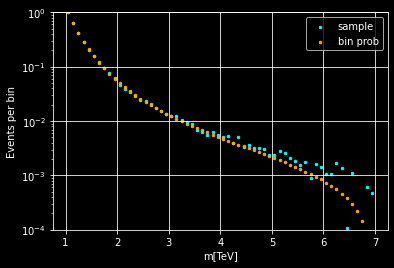

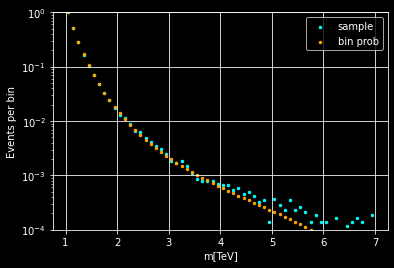

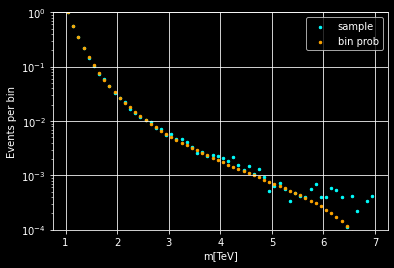

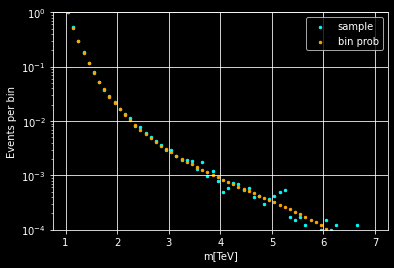

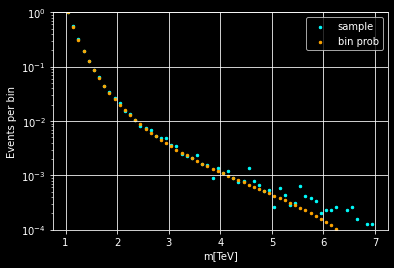

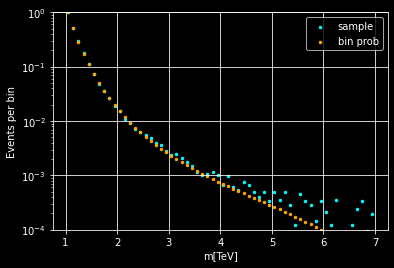

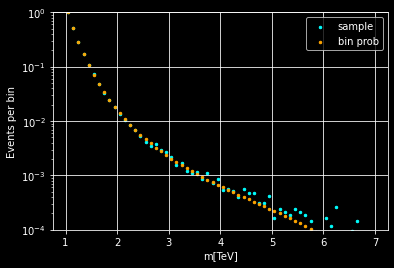

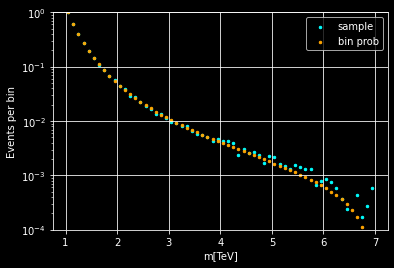

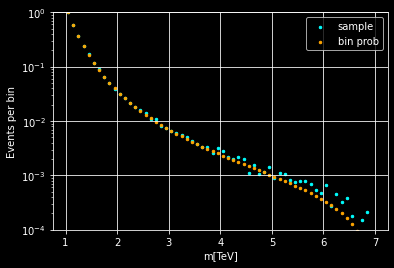

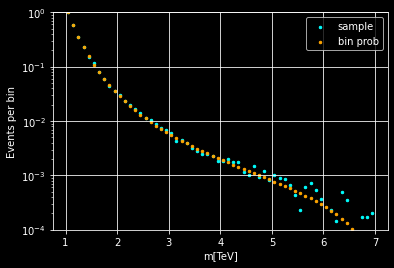

In [10]:
for i in np.random.randint(NP, size=10):
    plot1(X[i,:], Y[i,:])

In [11]:
import tensorflow.keras as keras
import tensorflow as tf

In [12]:
# Try LSTM s2s
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.

In [13]:
Y_shifted = np.roll(Y,1)

In [82]:
def create_s2s():
    # Define an input sequence and process it.
    encoder_inputs = keras.Input(shape=(None, 1))
    encoder = keras.layers.LSTM(latent_dim, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)

    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]

    # Set up the decoder, using `encoder_states` as initial state.
    decoder_inputs = keras.Input(shape=(None, 1))

    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = keras.layers.Dense(1, activation="linear")
    decoder_outputs = decoder_dense(decoder_outputs)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
    return model

In [85]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, 
                                           patience=25, verbose=0,
                                           mode='auto', baseline=None,
                                           restore_best_weights=True)]
TRAIN = False
if TRAIN:
    model = create_s2s()
    model.compile(
        optimizer="adam", loss="mse"
    )
    model.fit(
        [X, Y_shifted],
        Y,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.2,
        callbacks=callbacks
    )
    # Save model
    model.save("s2s")

In [86]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
if TRAIN:
    model = keras.models.load_model("s2s")
else:  
    model = keras.models.load_model("s2s_256_stable")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,), name="input_5")
decoder_state_input_c = keras.Input(shape=(latent_dim,), name="input_6")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

In [15]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, 1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, 0] = 0.5

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_dist = []
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_char = output_tokens[0,0,0]
        #print(sampled_char)
        decoded_dist.append(sampled_char)

        # Exit condition: either hit max length
        if len(decoded_dist) == 60:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, 1))
        target_seq[0, 0, 0] = sampled_char

        # Update states
        states_value = [h, c]
    return decoded_dist

In [16]:
def test1(lowp, highp, ne=NE, plot=True):
    X_test,Y_test,binsc= data_gen(lowp,highp,ne,1,f,scaled=True)
    X_test = X_test.reshape(1, X_test.shape[0], 1)
    Y_test = Y_test.reshape(1, Y_test.shape[0], 1)

    Y_hat = decode_sequence(X_test)
    print(sum(Y_hat))

    if plot:
        plt.grid()
        plt.ylim((10**-4,10**0))
        plt.yscale("log")
        plt.scatter(binsc,X_test, s=6, label="sample",c="cyan")
        plt.scatter(binsc, prob2event(Y_test), s=6, label="true bin prob", c="orange")
        plt.scatter(binsc, prob2event(Y_hat), s=6, label="predict bin prob", c="red")
        plt.xlabel("m[TeV]")
        plt.ylabel("Events per bin")
        plt.title("Test on parametric ({},{})".format(lowp, highp))
        plt.legend()
        plt.show()
    return X_test, Y_test, Y_hat

1.2835860466584563


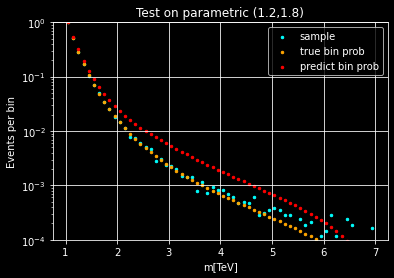

1.2288209265097976


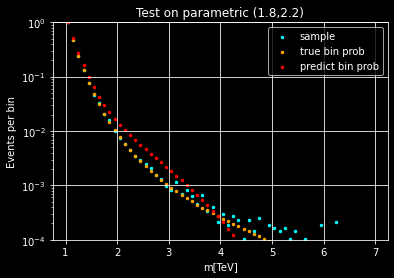

1.316129434388131


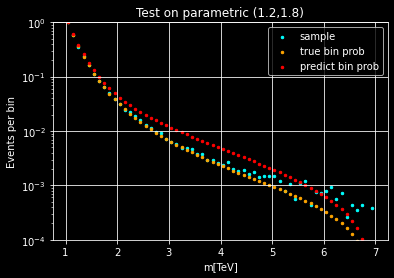

1.2101957867853343


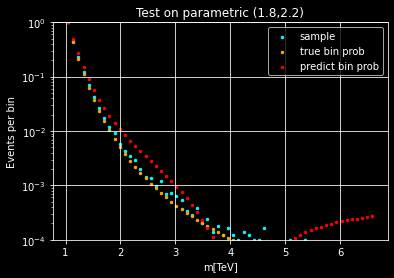

1.2915495038032532


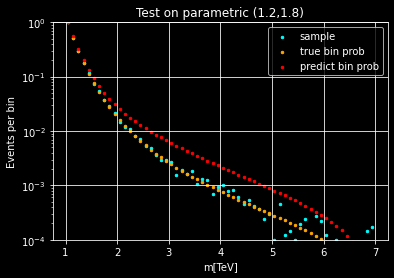

1.227686473634094


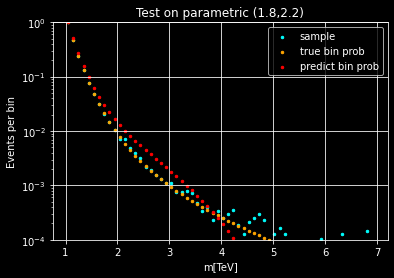

1.2972646793350577


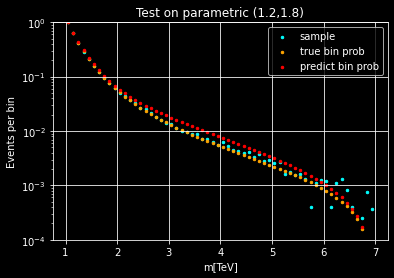

1.262129700742662


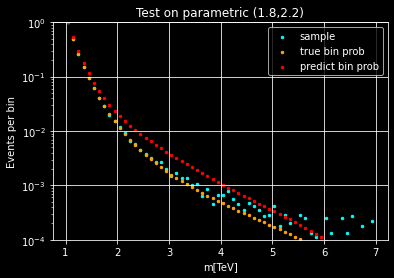

1.3064319267868996


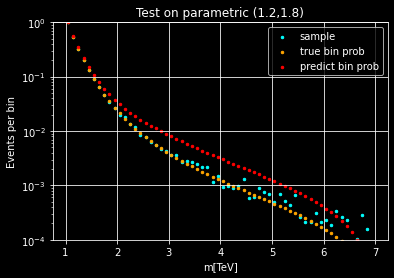

1.2579065961763263


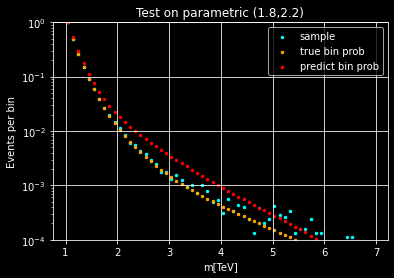

1.315804498270154


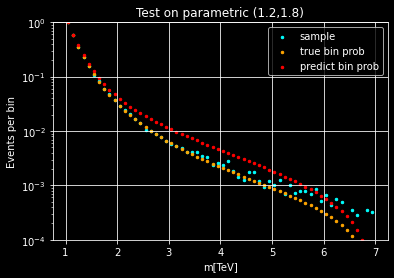

1.240269672125578


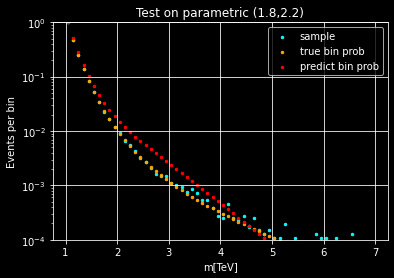

1.2831135704182088


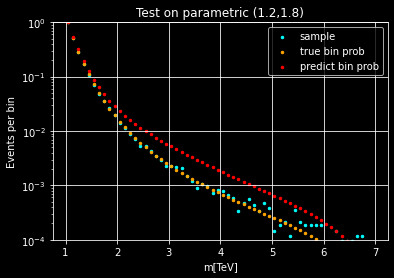

1.1915394430980086


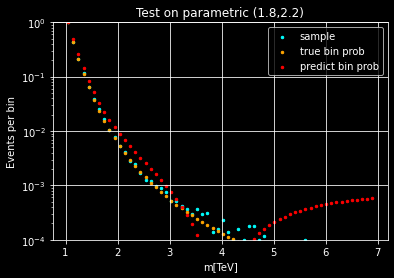

1.3141774977557361


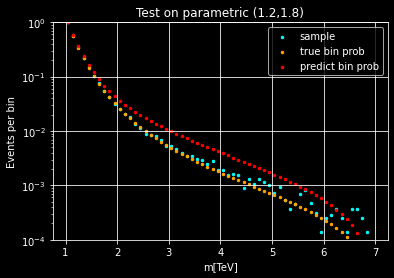

1.195686652790755


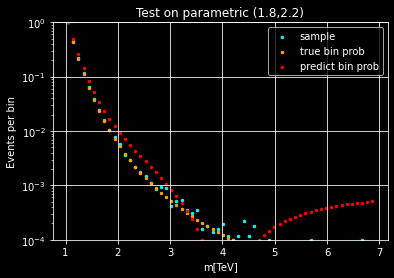

1.3004186409525573


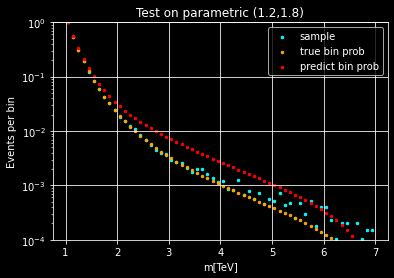

1.2052134219557047


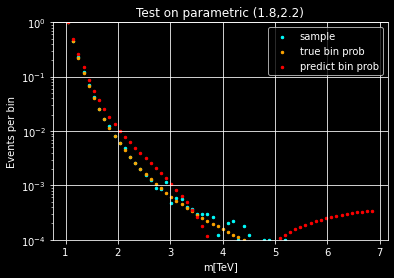

1.3149876678362489


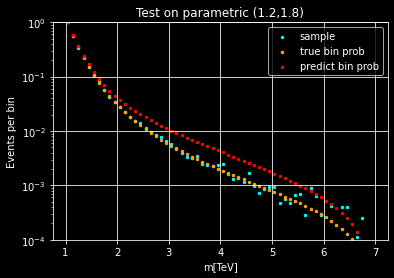

1.209514340851456


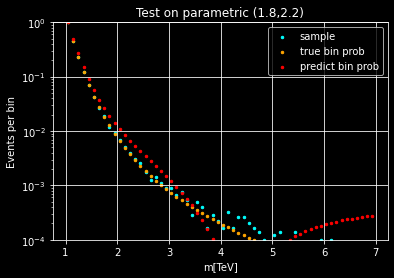

In [17]:
for i in range(10):
    test1(1.2,1.8)
    test1(1.8,2.2)

In [18]:
def probs2events(X):
    X = X.reshape(NP, NBINS)
    res = np.zeros((NP, NBINS))
    for i in range(X.shape[0]):
        x = X[i]
        x.reshape(NBINS)
        scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
        x = (x * NE) 
        x = scaler.fit_transform(x.reshape(-1,1))
        x = x.reshape(NBINS)
        res[i] = x
    return res

In [19]:
peY = probs2events(Y)

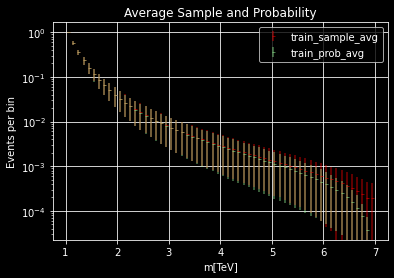

In [20]:
pX = X.reshape(X.shape[0], X.shape[1])
pY = Y.reshape(Y.shape[0], Y.shape[1])

X_avg = np.average(pX, axis=0)
X_var = np.std(pX, axis=0)

Y_avg = np.average(peY, axis=0)
Y_var = np.std(peY, axis=0)

plt.yscale("log")
plt.errorbar(binsc, X_avg, yerr=X_var, fmt='_',markersize=3, label="train_sample_avg", alpha=0.5, color="red")
plt.errorbar(binsc, Y_avg, yerr=Y_var, fmt='_',markersize=3, label="train_prob_avg", alpha=0.5, color="palegreen")
plt.grid()
plt.xlabel("m[TeV]")
plt.ylabel("Events per bin")
plt.title("Average Sample and Probability")
plt.legend()
plt.show()

1.2845360366627574


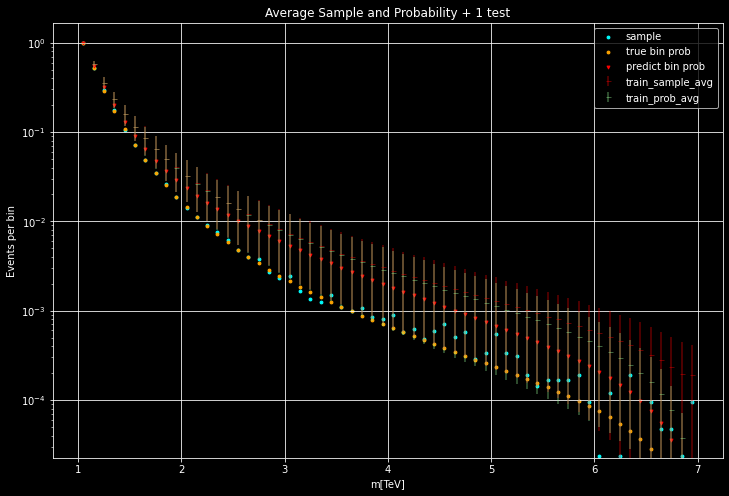

1.309100305661559


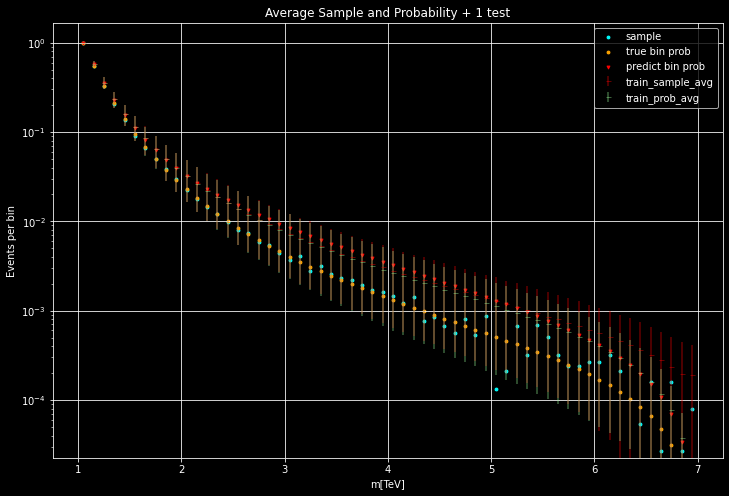

1.3015877986326814


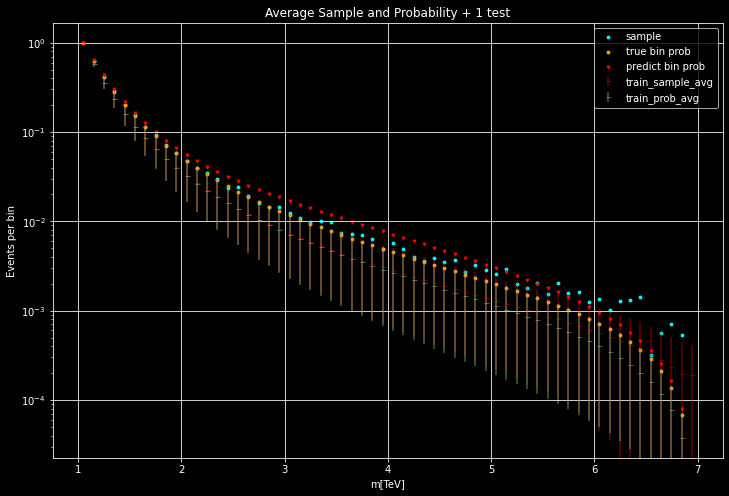

1.3067183527164161


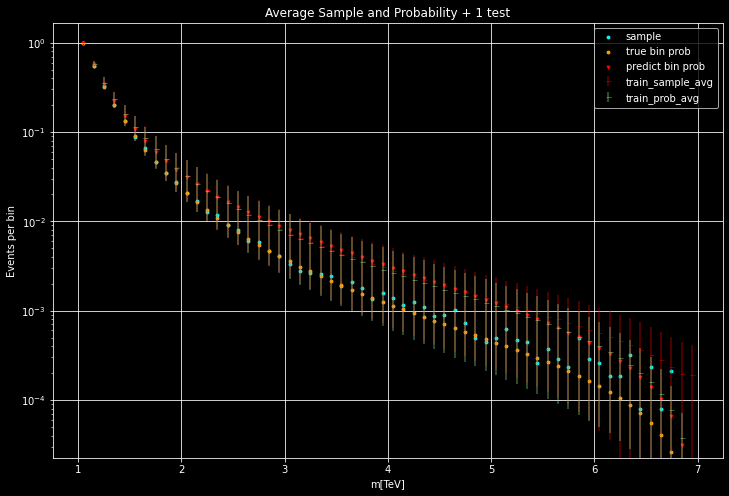

1.3101101201027632


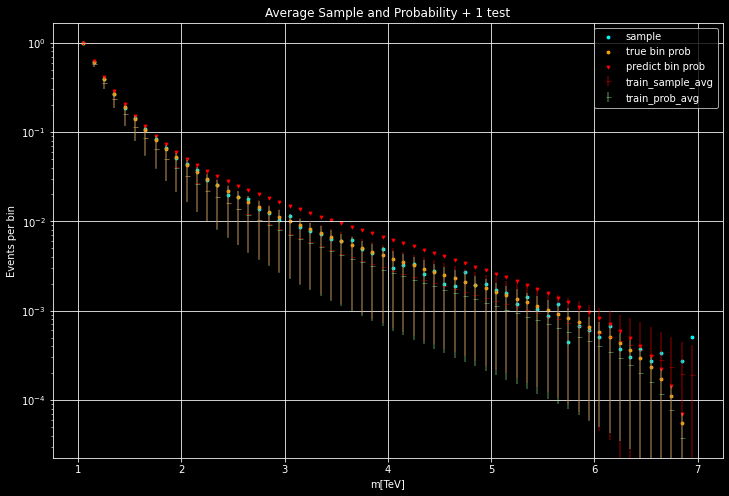

In [87]:
pX = X.reshape(X.shape[0], X.shape[1])
pY = Y.reshape(Y.shape[0], Y.shape[1])

X_avg = np.average(pX, axis=0)
X_var = np.std(pX, axis=0)

Y_avg = np.average(peY, axis=0)
Y_var = np.std(peY, axis=0)


for i in range(5):
    X_test, Y_test, Y_hat = test1(1.2, 1.8, plot=False)
    plt.figure(figsize=(12,8))
    plt.yscale("log")
    plt.errorbar(binsc, X_avg, yerr=X_var, fmt='_',markersize=5, label="train_sample_avg",alpha=0.4,color="red")
    plt.errorbar(binsc, Y_avg, yerr=Y_var, fmt='_',markersize=5, label="train_prob_avg",alpha=0.4, color="palegreen")
    plt.scatter(binsc,X_test, s=8, label="sample", color="cyan")
    plt.scatter(binsc, prob2event(Y_test), s=8, label="true bin prob", c="orange")
    plt.scatter(binsc, prob2event(Y_hat), s=8, label="predict bin prob", marker='v',c="red")
    plt.grid()
    plt.xlabel("m[TeV]")
    plt.ylabel("Events per bin")
    plt.title("Average Sample and Probability + 1 test")
    plt.legend()
    plt.show()

## Compare with simple Dense Network

In [88]:
def create_model(inx):
    # Create the model 
    #initializer = tf.keras.initializers.Identity()
    model = keras.Sequential()
    model.add(keras.layers.Dense(units = inx, activation = 'linear', input_shape=[inx]))
    model.add(keras.layers.Dense(units = 64, activation = 'relu'))
    model.add(keras.layers.Dense(units = 128, activation = 'relu'))
    model.add(keras.layers.Dense(units = 128, activation = 'relu'))
    model.add(keras.layers.Dense(units = 64, activation = 'relu'))
    model.add(keras.layers.Dense(units = inx, activation = 'linear'))
    model.compile(loss='mse', optimizer="adam")

    # Display the model
    model.summary()

    return model

In [89]:
model_dnn = create_model(60)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 60)                3660      
_________________________________________________________________
dense_26 (Dense)             (None, 64)                3904      
_________________________________________________________________
dense_27 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_28 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_29 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_30 (Dense)             (None, 60)                3900      
Total params: 44,552
Trainable params: 44,552
Non-trainable params: 0
__________________________________________________

In [90]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, 
                                           patience=15, verbose=0,
                                           mode='auto', baseline=None,
                                           restore_best_weights=True)]

In [91]:
pX = X.reshape(X.shape[0], X.shape[1])
pY = Y.reshape(Y.shape[0], Y.shape[1])
model_dnn.fit(pX, pY, epochs=100, verbose=1, batch_size=16, callbacks=callbacks, validation_split=0.4)

Epoch 1/100
375/375 [==============================] - 1s 2ms/step - loss: 1.1365e-04 - val_loss: 6.8279e-07
Epoch 2/100
375/375 [==============================] - 1s 2ms/step - loss: 3.8439e-07 - val_loss: 2.8837e-07
Epoch 3/100
375/375 [==============================] - 1s 2ms/step - loss: 3.4887e-07 - val_loss: 3.9142e-07
Epoch 4/100
375/375 [==============================] - 1s 2ms/step - loss: 3.5233e-07 - val_loss: 2.9994e-07
Epoch 5/100
375/375 [==============================] - 1s 2ms/step - loss: 3.5342e-07 - val_loss: 3.2952e-07
Epoch 6/100
375/375 [==============================] - 1s 2ms/step - loss: 3.4779e-07 - val_loss: 2.2040e-07
Epoch 7/100
375/375 [==============================] - 1s 2ms/step - loss: 3.4924e-07 - val_loss: 4.2887e-07
Epoch 8/100
375/375 [==============================] - 1s 2ms/step - loss: 3.6149e-07 - val_loss: 4.0789e-07
Epoch 9/100
375/375 [==============================] - 1s 2ms/step - loss: 2.8748e-07 - val_loss: 5.5340e-07
Epoch 10/100
375/37

In [92]:
def test1vsDNN(lowp, highp, ne=NE, plot=True):
    X_test,Y_test,binsc= data_gen(lowp,highp,ne,1,f,scaled=True)
    X_test = X_test.reshape(1, NBINS)
    Y_hat_dnn = model_dnn.predict(X_test)
    
    X_test = X_test.reshape(1, NBINS, 1)
    Y_hat = decode_sequence(X_test)
    #print(Y_hat_dnn)
    print(sum(Y_hat), np.sum(Y_hat_dnn), np.sum(X_test), np.sum(X_test.reshape(1,60)))

    if plot:
        plt.grid()
        plt.ylim((10**-4,10**0))
        plt.yscale("log")
        plt.scatter(binsc,X_test, s=6, label="sample", c="cyan")
        plt.scatter(binsc, prob2event(Y_test), s=6, label="true bin prob", c="orange")
        plt.scatter(binsc, prob2event(Y_hat), s=6, label="LSTM predict bin prob", marker='v',c="red")
        plt.scatter(binsc, prob2event(Y_hat_dnn), s=6, marker='^', label="DNN predict bin prob", c="violet")
        plt.xlabel("m[TeV]")
        plt.ylabel("Events per bin")
        plt.title("LSTM vs DNN Test on parametric ({},{})".format(lowp, highp))
        plt.legend()
        plt.show()
    return X_test, Y_test, Y_hat

1.2978817615658045 1.0016232 3.496657606699478 3.496657606699478


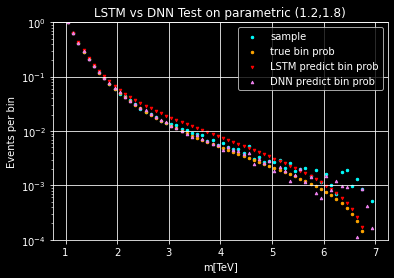

1.2958958055824041 1.0020546 2.4769433465085644 2.4769433465085644


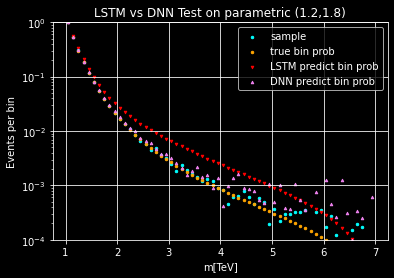

1.2679709722287953 1.0012761 3.9484510116698845 3.9484510116698845


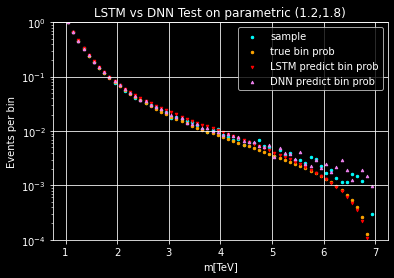

1.3108068006113172 1.0024594 2.6805349182763742 2.6805349182763742


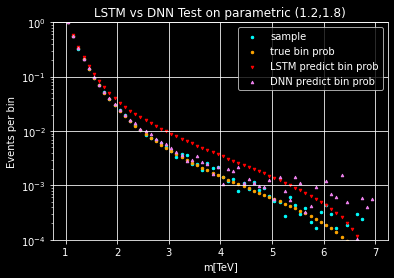

1.3042812063358724 1.0016503 3.3837070359176216 3.3837070359176216


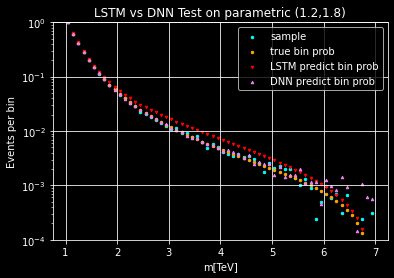

1.2760436688549817 1.0019695 2.3208095847388623 2.3208095847388623


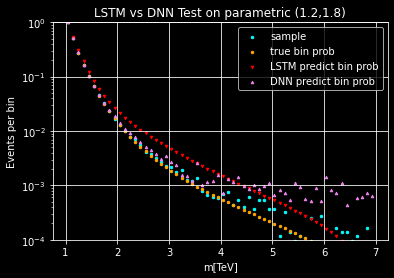

1.2672495087608695 1.002121 2.2673480976717775 2.2673480976717775


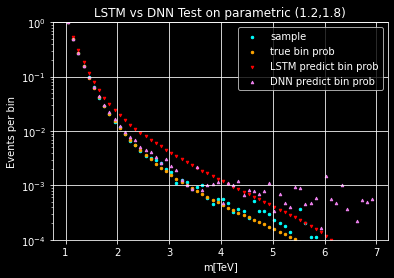

1.2812453717924654 1.001693 2.3560234138972804 2.3560234138972804


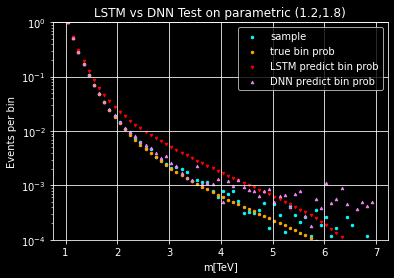

1.276426323223859 1.0006163 3.83206862421643 3.83206862421643


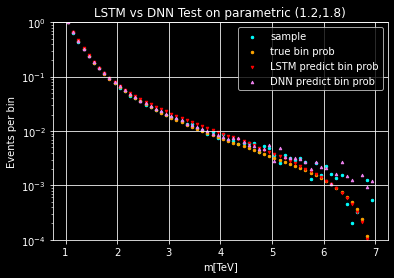

1.292293471749872 1.0017679 2.4441608168474787 2.4441608168474787


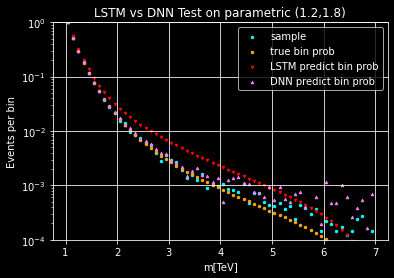

In [93]:
for i in range(10):
    _ = test1vsDNN(1.2, 1.8)